In [2]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
import torchvision.models as models

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Load Data

In [4]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),

    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
dataset_path = "dataset"

dataset = datasets.ImageFolder(
    root=dataset_path, transform=image_transforms)
len(dataset)

2300

In [6]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [7]:
num_classes = len(dataset.classes)
num_classes

6

In [8]:
2300 * 0.75

1725.0

In [9]:
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(1725, 575)

In [10]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [12]:
for images, labels in train_loader:
  print(images.shape)
  print(labels.shape)
  break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [13]:
images[0]

tensor([[[-1.9980, -1.9980, -1.9980,  ..., -1.9980, -1.9980, -1.9980],
         [-1.9980, -1.9980, -1.9980,  ..., -1.9980, -1.9980, -1.9980],
         [-1.9980, -1.9980, -1.9980,  ..., -1.9980, -1.9980, -1.9980],
         ...,
         [-1.9980, -1.9980, -1.9980,  ..., -1.9980, -1.9980, -1.9980],
         [-1.9980, -1.9980, -1.9980,  ..., -1.9980, -1.9980, -1.9980],
         [-1.9980, -1.9980, -1.9980,  ..., -1.9980, -1.9980, -1.9980]],

        [[-1.9132, -1.9132, -1.9132,  ..., -1.9132, -1.9132, -1.9132],
         [-1.9132, -1.9132, -1.9132,  ..., -1.9132, -1.9132, -1.9132],
         [-1.9132, -1.9132, -1.9132,  ..., -1.9132, -1.9132, -1.9132],
         ...,
         [-1.9132, -1.9132, -1.9132,  ..., -1.9132, -1.9132, -1.9132],
         [-1.9132, -1.9132, -1.9132,  ..., -1.9132, -1.9132, -1.9132],
         [-1.9132, -1.9132, -1.9132,  ..., -1.9132, -1.9132, -1.9132]],

        [[-1.6824, -1.6824, -1.6824,  ..., -1.6824, -1.6824, -1.6824],
         [-1.6824, -1.6824, -1.6824,  ..., -1

In [14]:
images[0].shape

torch.Size([3, 224, 224])

In [15]:
labels[2]

tensor(2)

In [16]:
images[0].permute(1,2,0).shape

torch.Size([224, 224, 3])

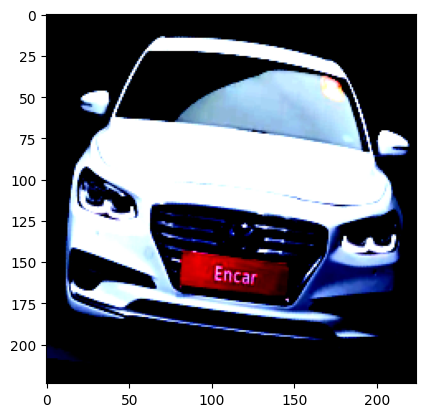

In [17]:
plt.imshow(images[0].permute(1,2,0))
plt.show()

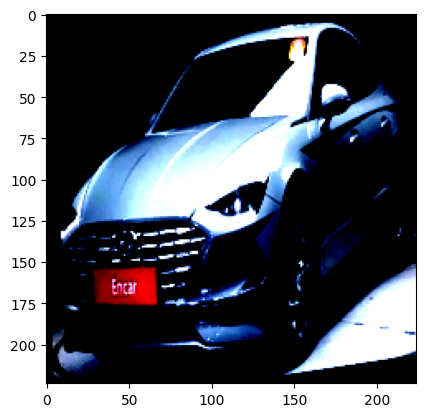

In [18]:
plt.imshow(images[2].permute(1,2,0))
plt.show()

## Model 1: CNN

In [19]:
class CarClassifierCNN(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1), # (3, 224, 224) -> (16, 224, 224)
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2), # (16, 224, 224) -> (16, 112, 112)
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1), # (16, 112, 112) -> (32, 112, 112)
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2), # (32, 112, 112) -> (32, 56, 56)
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1), # (32, 56, 56) -> (64, 56, 56)
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2), # (64, 56, 56) -> (64, 28, 28)

        nn.Flatten(),
        nn.Linear(64*28*28, 512),
        nn.ReLU(),
        nn.Linear(512, num_classes)
    )

  def forward(self, x):
    x = self.network(x)
    return x

In [20]:
model = CarClassifierCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
len(train_loader)

54

In [22]:
def train_model(model, criterion, epochs=5):
  start = time.time()

  for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_num, (images, labels) in enumerate(train_loader):
      images, labels = images.to(device), labels.to(device)

      # Zero the param gradients
      optimizer.zero_grad()


      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)

      # Backward pass and optimization
      loss.backward()
      optimizer.step()

      if(batch_num + 1) % 10 == 0:
        print(f"Batch: {batch_num + 1}, Epoch: {epoch + 1}, Loss: {loss.item():.2f}")

      running_loss += loss.item() # total batch loss
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} Avg Loss: {epoch_loss:.4f}")

    # Validation
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predicted = []

    with torch.no_grad():
      for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

      accuracy = 100 * correct / total
      print(f"*** Validation Accuracy: {accuracy:.2f}% ***")
      print()
  end = time.time()
  print(f"Training time: {end - start:.2f} seconds")
  return all_labels, all_predicted


In [23]:
all_labels, all_predicted = train_model(model, criterion, epochs=5)

Batch: 10, Epoch: 1, Loss: 1.77
Batch: 20, Epoch: 1, Loss: 1.48
Batch: 30, Epoch: 1, Loss: 1.52
Batch: 40, Epoch: 1, Loss: 1.41
Batch: 50, Epoch: 1, Loss: 1.20
Epoch 1/5 Avg Loss: 1.5799
*** Validation Accuracy: 47.13% ***

Batch: 10, Epoch: 2, Loss: 0.97
Batch: 20, Epoch: 2, Loss: 1.02
Batch: 30, Epoch: 2, Loss: 1.33
Batch: 40, Epoch: 2, Loss: 1.50
Batch: 50, Epoch: 2, Loss: 1.03
Epoch 2/5 Avg Loss: 1.1428
*** Validation Accuracy: 53.04% ***

Batch: 10, Epoch: 3, Loss: 1.28
Batch: 20, Epoch: 3, Loss: 1.00
Batch: 30, Epoch: 3, Loss: 0.97
Batch: 40, Epoch: 3, Loss: 1.00
Batch: 50, Epoch: 3, Loss: 1.05
Epoch 3/5 Avg Loss: 0.9997
*** Validation Accuracy: 54.61% ***

Batch: 10, Epoch: 4, Loss: 0.82
Batch: 20, Epoch: 4, Loss: 0.93
Batch: 30, Epoch: 4, Loss: 1.12
Batch: 40, Epoch: 4, Loss: 0.92
Batch: 50, Epoch: 4, Loss: 0.80
Epoch 4/5 Avg Loss: 0.9202
*** Validation Accuracy: 54.78% ***

Batch: 10, Epoch: 5, Loss: 0.78
Batch: 20, Epoch: 5, Loss: 0.86
Batch: 30, Epoch: 5, Loss: 0.74
Batch: 4

## Model 2: CNN with Regularization

In [25]:
class CarClassifierCNNWithRegularization(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1), # (3, 224, 224) -> (16, 224, 224)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2), # (16, 224, 224) -> (16, 112, 112)
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1), # (16, 112, 112) -> (32, 112, 112)
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2), # (32, 112, 112) -> (32, 56, 56)
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1), # (32, 56, 56) -> (64, 56, 56)
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2), # (64, 56, 56) -> (64, 28, 28)
        nn.Flatten(),
        nn.Linear(64*28*28, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )

  def forward(self, x):
    x = self.network(x)
    return x

In [26]:
model = CarClassifierCNNWithRegularization(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [27]:
all_labels, all_predicted = train_model(model, criterion, epochs=5)

Batch: 10, Epoch: 1, Loss: 5.77
Batch: 20, Epoch: 1, Loss: 2.55
Batch: 30, Epoch: 1, Loss: 1.50
Batch: 40, Epoch: 1, Loss: 1.71
Batch: 50, Epoch: 1, Loss: 1.53
Epoch 1/5 Avg Loss: 6.3999
*** Validation Accuracy: 38.61% ***

Batch: 10, Epoch: 2, Loss: 1.18
Batch: 20, Epoch: 2, Loss: 1.61
Batch: 30, Epoch: 2, Loss: 1.44
Batch: 40, Epoch: 2, Loss: 1.15
Batch: 50, Epoch: 2, Loss: 1.17
Epoch 2/5 Avg Loss: 1.3764
*** Validation Accuracy: 48.17% ***

Batch: 10, Epoch: 3, Loss: 1.38
Batch: 20, Epoch: 3, Loss: 1.31
Batch: 30, Epoch: 3, Loss: 1.39
Batch: 40, Epoch: 3, Loss: 1.13
Batch: 50, Epoch: 3, Loss: 1.18
Epoch 3/5 Avg Loss: 1.2367
*** Validation Accuracy: 48.52% ***

Batch: 10, Epoch: 4, Loss: 1.13
Batch: 20, Epoch: 4, Loss: 0.97
Batch: 30, Epoch: 4, Loss: 1.31
Batch: 40, Epoch: 4, Loss: 1.10
Batch: 50, Epoch: 4, Loss: 1.15
Epoch 4/5 Avg Loss: 1.1627
*** Validation Accuracy: 50.09% ***

Batch: 10, Epoch: 5, Loss: 1.00
Batch: 20, Epoch: 5, Loss: 1.09
Batch: 30, Epoch: 5, Loss: 1.29
Batch: 4

## Model 3: Transfer Learning with EfficientNet

In [28]:
class CarClassifierEfficientNet(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.model = models.efficientnet_b0(weights='DEFAULT')

    for param in self.model.parameters():
      param.requires_grad = False

    in_features = self.model.classifier[1].in_features

    self.model.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(in_features, num_classes)
    )

  def forward(self, x):
    x = self.model(x)
    return x

In [30]:
model = CarClassifierEfficientNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 135MB/s]


In [31]:
all_labels, all_predicted = train_model(model, criterion, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.71
Batch: 20, Epoch: 1, Loss: 1.63
Batch: 30, Epoch: 1, Loss: 1.47
Batch: 40, Epoch: 1, Loss: 1.41
Batch: 50, Epoch: 1, Loss: 1.11
Epoch 1/10 Avg Loss: 1.4930
*** Validation Accuracy: 51.83% ***

Batch: 10, Epoch: 2, Loss: 1.15
Batch: 20, Epoch: 2, Loss: 1.04
Batch: 30, Epoch: 2, Loss: 1.03
Batch: 40, Epoch: 2, Loss: 1.10
Batch: 50, Epoch: 2, Loss: 1.08
Epoch 2/10 Avg Loss: 1.1245
*** Validation Accuracy: 55.48% ***

Batch: 10, Epoch: 3, Loss: 0.97
Batch: 20, Epoch: 3, Loss: 0.94
Batch: 30, Epoch: 3, Loss: 0.80
Batch: 40, Epoch: 3, Loss: 0.97
Batch: 50, Epoch: 3, Loss: 0.91
Epoch 3/10 Avg Loss: 0.9987
*** Validation Accuracy: 57.39% ***

Batch: 10, Epoch: 4, Loss: 0.91
Batch: 20, Epoch: 4, Loss: 0.82
Batch: 30, Epoch: 4, Loss: 0.83
Batch: 40, Epoch: 4, Loss: 1.05
Batch: 50, Epoch: 4, Loss: 0.79
Epoch 4/10 Avg Loss: 0.9357
*** Validation Accuracy: 61.04% ***

Batch: 10, Epoch: 5, Loss: 0.88
Batch: 20, Epoch: 5, Loss: 0.99
Batch: 30, Epoch: 5, Loss: 0.87
Batc

## Model 4: Transfer Learning with ResNet

In [32]:
class CarClassifierResNet(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.model = models.resnet50(weights='DEFAULT')

    for param in self.model.parameters():
      param.requires_grad = False

    for param in self.model.layer4.parameters():
      param.requires_grad = True

    in_features = self.model.fc.in_features

    self.model.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(in_features, num_classes)
    )

  def forward(self, x):
    x = self.model(x)
    return x

In [33]:
model = CarClassifierResNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]


In [34]:
all_labels, all_predicted = train_model(model, criterion, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.20
Batch: 20, Epoch: 1, Loss: 1.18
Batch: 30, Epoch: 1, Loss: 0.70
Batch: 40, Epoch: 1, Loss: 0.86
Batch: 50, Epoch: 1, Loss: 0.52
Epoch 1/10 Avg Loss: 0.8724
*** Validation Accuracy: 68.00% ***

Batch: 10, Epoch: 2, Loss: 0.40
Batch: 20, Epoch: 2, Loss: 0.46
Batch: 30, Epoch: 2, Loss: 0.37
Batch: 40, Epoch: 2, Loss: 0.62
Batch: 50, Epoch: 2, Loss: 0.35
Epoch 2/10 Avg Loss: 0.5008
*** Validation Accuracy: 78.09% ***

Batch: 10, Epoch: 3, Loss: 0.34
Batch: 20, Epoch: 3, Loss: 0.18
Batch: 30, Epoch: 3, Loss: 0.17
Batch: 40, Epoch: 3, Loss: 0.35
Batch: 50, Epoch: 3, Loss: 0.24
Epoch 3/10 Avg Loss: 0.3109
*** Validation Accuracy: 77.22% ***

Batch: 10, Epoch: 4, Loss: 0.26
Batch: 20, Epoch: 4, Loss: 0.15
Batch: 30, Epoch: 4, Loss: 0.13
Batch: 40, Epoch: 4, Loss: 0.06
Batch: 50, Epoch: 4, Loss: 0.22
Epoch 4/10 Avg Loss: 0.2350
*** Validation Accuracy: 76.87% ***

Batch: 10, Epoch: 5, Loss: 0.25
Batch: 20, Epoch: 5, Loss: 0.27
Batch: 30, Epoch: 5, Loss: 0.17
Batc

## Hyperparameter Tuning using Optuna

In [36]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 10.2 MB/s eta 0:00:00


In [37]:
import optuna

In [41]:
class CarClassifierResNet(nn.Module):
  def __init__(self, num_classes, dropout_rate=0.5):
    super().__init__()
    self.model = models.resnet50(weights='DEFAULT')

    for param in self.model.parameters():
      param.requires_grad = False

    for param in self.model.layer4.parameters():
      param.requires_grad = True

    in_features = self.model.fc.in_features

    self.model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(in_features, num_classes)
    )

  def forward(self, x):
    x = self.model(x)
    return x

In [44]:
def objective(trial):
  lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
  dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.7)

  model = CarClassifierResNet(num_classes=num_classes, dropout_rate=dropout_rate).to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

  epochs = 3
  start = time.time()
  for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_num, (images, labels) in enumerate(train_loader):
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
      for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

      accuracy = 100 * correct / total

      trial.report(accuracy, epoch)

      if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
  end = time.time()
  print(f"Execution time: {end - start} seconds.")

  return accuracy


In [45]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2025-11-17 14:44:11,934] A new study created in memory with name: no-name-e00f682e-4c96-4421-8b28-df784b90072f
[I 2025-11-17 14:48:02,253] Trial 0 finished with value: 76.69565217391305 and parameters: {'lr': 0.0002109074701575305, 'dropout_rate': 0.4247490383576915}. Best is trial 0 with value: 76.69565217391305.


Execution time: 229.845228433609 seconds.


[I 2025-11-17 14:52:24,841] Trial 1 finished with value: 53.73913043478261 and parameters: {'lr': 1.9248176019393342e-05, 'dropout_rate': 0.315238283543266}. Best is trial 0 with value: 76.69565217391305.


Execution time: 262.11922311782837 seconds.


[I 2025-11-17 14:56:19,226] Trial 2 finished with value: 74.6086956521739 and parameters: {'lr': 0.00017227485030817677, 'dropout_rate': 0.3823201058322655}. Best is trial 0 with value: 76.69565217391305.


Execution time: 233.65291953086853 seconds.


[I 2025-11-17 15:00:12,500] Trial 3 finished with value: 67.1304347826087 and parameters: {'lr': 3.764365454434006e-05, 'dropout_rate': 0.2608225750975229}. Best is trial 0 with value: 76.69565217391305.


Execution time: 232.81510829925537 seconds.


[I 2025-11-17 15:04:01,009] Trial 4 finished with value: 73.91304347826087 and parameters: {'lr': 0.0019077149616690012, 'dropout_rate': 0.6546034427629231}. Best is trial 0 with value: 76.69565217391305.


Execution time: 228.0414707660675 seconds.


[I 2025-11-17 15:05:17,335] Trial 5 pruned. 
[I 2025-11-17 15:07:49,228] Trial 6 pruned. 
[I 2025-11-17 15:11:38,730] Trial 7 finished with value: 74.78260869565217 and parameters: {'lr': 0.0008479552523912693, 'dropout_rate': 0.640838956687539}. Best is trial 0 with value: 76.69565217391305.


Execution time: 229.0496325492859 seconds.


[I 2025-11-17 15:15:27,337] Trial 8 finished with value: 77.73913043478261 and parameters: {'lr': 0.0007256538817205548, 'dropout_rate': 0.5570626498321368}. Best is trial 8 with value: 77.73913043478261.


Execution time: 228.13313579559326 seconds.


[I 2025-11-17 15:16:43,513] Trial 9 pruned. 


In [46]:
study.best_params

{'lr': 0.0007256538817205548, 'dropout_rate': 0.5570626498321368}

## Train the model again with best parameters

In [47]:
def train_model(model, criterion, optimizer, epochs=5):
    """
    Trains and validates the PyTorch model over a specified number of epochs.
    """
    start = time.time()

    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        running_loss = 0.0

        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Zero the param gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate the mean batch loss
            running_loss += loss.item()

            if (batch_num + 1) % 10 == 0:
                print(f"Batch: {batch_num + 1}, Epoch: {epoch + 1}, Loss: {loss.item():.2f}")

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} Avg Loss: {epoch_loss:.4f}")

        # --- Validation Phase ---
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predicted = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                # Get predictions
                _, predicted = torch.max(outputs.data, 1)

                # Calculate metrics
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Store all labels/predictions for post-analysis
                all_labels.extend(labels.cpu().numpy())
                all_predicted.extend(predicted.cpu().numpy())

            accuracy = 100 * correct / total
            print(f"*** Validation Accuracy: {accuracy:.2f}% ***")
            print()

    end = time.time()
    print(f"Training time: {end - start:.2f} seconds")

    # Return all labels and predictions from the final epoch's validation run
    return all_labels, all_predicted

In [48]:
best_params = study.best_params
best_lr = best_params['lr']
best_dropout = best_params['dropout_rate']

model = CarClassifierResNet(num_classes=num_classes, dropout_rate=best_dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=best_lr)

In [49]:
labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.09
Batch: 20, Epoch: 1, Loss: 0.60
Batch: 30, Epoch: 1, Loss: 1.32
Batch: 40, Epoch: 1, Loss: 0.66
Batch: 50, Epoch: 1, Loss: 0.75
Epoch 1/10 Avg Loss: 0.9012
*** Validation Accuracy: 73.22% ***

Batch: 10, Epoch: 2, Loss: 0.53
Batch: 20, Epoch: 2, Loss: 0.37
Batch: 30, Epoch: 2, Loss: 0.39
Batch: 40, Epoch: 2, Loss: 0.33
Batch: 50, Epoch: 2, Loss: 0.35
Epoch 2/10 Avg Loss: 0.4589
*** Validation Accuracy: 73.22% ***

Batch: 10, Epoch: 3, Loss: 0.25
Batch: 20, Epoch: 3, Loss: 0.54
Batch: 30, Epoch: 3, Loss: 0.34
Batch: 40, Epoch: 3, Loss: 0.43
Batch: 50, Epoch: 3, Loss: 0.38
Epoch 3/10 Avg Loss: 0.3262
*** Validation Accuracy: 76.52% ***

Batch: 10, Epoch: 4, Loss: 0.12
Batch: 20, Epoch: 4, Loss: 0.16
Batch: 30, Epoch: 4, Loss: 0.09
Batch: 40, Epoch: 4, Loss: 0.22
Batch: 50, Epoch: 4, Loss: 0.50
Epoch 4/10 Avg Loss: 0.2055
*** Validation Accuracy: 77.57% ***

Batch: 10, Epoch: 5, Loss: 0.14
Batch: 20, Epoch: 5, Loss: 0.19
Batch: 30, Epoch: 5, Loss: 0.13
Batc

## Model Evaluation using Confusion Matrix and Classification Report

In [50]:
labels[:10], predictions[:10]

([np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(4),
  np.int64(5),
  np.int64(4),
  np.int64(3),
  np.int64(4),
  np.int64(1)],
 [np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(4),
  np.int64(5),
  np.int64(4),
  np.int64(3),
  np.int64(4),
  np.int64(1)])

In [51]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       110
           1       0.77      0.68      0.72        97
           2       0.88      0.86      0.87       116
           3       0.87      0.69      0.77        90
           4       0.61      0.79      0.69        78
           5       0.77      0.74      0.75        84

    accuracy                           0.78       575
   macro avg       0.78      0.77      0.77       575
weighted avg       0.79      0.78      0.78       575



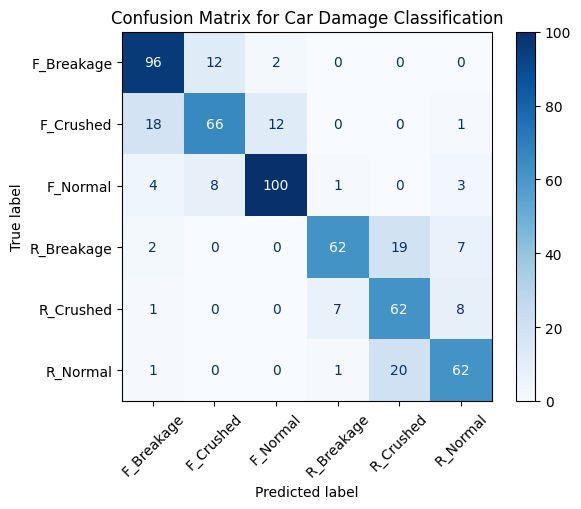

In [52]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

class_names = dataset.classes

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Car Damage Classification")
plt.show()

In [53]:
torch.save(model.state_dict(), 'saved_model.pth')